In [1]:
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
#check librosa stft and istft
import os
import sys
import numpy as np
import copy
import scipy

from sklearn.preprocessing import normalize

sys.path.insert(0, "/home/anonymous/Desktop/eeg_sampling/modeling")
from dataio import readdata2, readlabels2, writedata
from datafilters import apply_dc_filter, apply_dwt_filter
from wignerville import wvd, filtered_wvd

In [3]:
#predataset = readdata2("./../curated/raw-presamples")
dataset = readdata2("./../curated/raw-samples")
labels = readlabels2("./../curated/raw-inputs")

#Constants
fs = 250.0 #Frequency in Hz
sample_time = dataset[0].shape[1]/fs #Total time for sample
num_rows = 480 
num_channels = 8
rto = num_rows/(fs/2)

In [4]:
#Samples
data = []
data_avg = []
#sams = [6, 12, 32, 40, 50]
sams = [7,32,18,4,9]
channLEFT = 3
channRIGHT = 1
for i in range(0, len(sams)):
    data.append(dataset[0][sams[i],:,channLEFT])
    data_avg.append(dataset[0][sams[i],:,channRIGHT])
    #data_avg.append(np.mean(dataset[0],axis=2)[sams[i]])

In [5]:
data_dc = []
data_dc_avg = []

#First filter
dc_lowcut = 9.0
dc_highcut = 11.0
dc_order = 2
dc_type = "bandpass"
dc_func_type = "butter"
for i in range(0, len(sams)):
    data_dc.append(apply_dc_filter(data[i], fs, dc_lowcut, dc_highcut, dc_order, dc_type, dc_func_type))
    data_dc_avg.append(apply_dc_filter(data_avg[i], fs, dc_lowcut, dc_highcut, dc_order, dc_type, dc_func_type))

#First filter
dc_lowcut = 59.0
dc_highcut = 61.0
dc_order = 2
dc_type = "bandstop"
dc_func_type = "butter"
for i in range(0, len(sams)):
    data_dc[i] = apply_dc_filter(data_dc[i], fs, dc_lowcut, dc_highcut, dc_order, dc_type, dc_func_type)
    data_dc_avg[i] = apply_dc_filter(data_dc_avg[i], fs, dc_lowcut, dc_highcut, dc_order, dc_type, dc_func_type)

In [6]:
#Sample Cut in sec (before transform)
front_cut = 0.000
back_cut = 0.000
cut_values = np.concatenate([np.arange(0, int(front_cut * fs)), np.arange(480 - int(back_cut * fs), 480)])
for i in range(0, len(sams)):
    data_dc[i] = np.delete(data_dc[i], cut_values, 0)
    data_dc_avg[i] = np.delete(data_dc_avg[i], cut_values, 0)
    
total_sample_time = sample_time - front_cut - back_cut

In [7]:
#Wigner-Ville Transform
data_wv = []
data_wv_avg = []
for i in range(0, len(sams)):
    data_wv.append(wvd(data_dc[i])[0])
    data_wv_avg.append(wvd(data_dc_avg[i])[0])

In [8]:
#Normalize Data
for i in range(0, len(sams)):
    data_wv[i] = normalize(data_wv[i], axis=1, norm='l1')
    data_wv_avg[i] = normalize(data_wv_avg[i], axis=1, norm='l1')

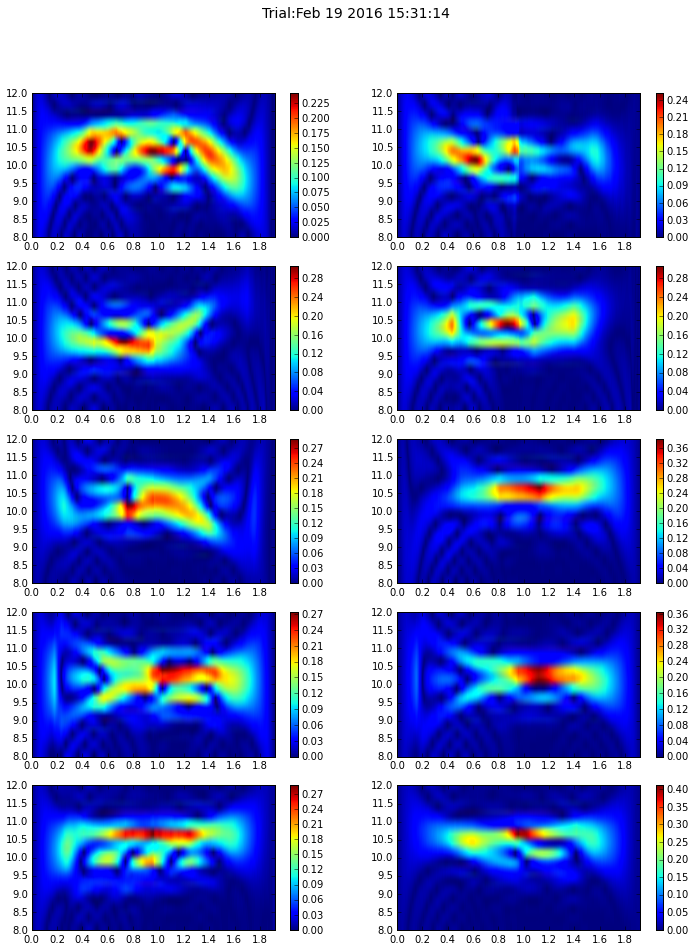

In [9]:
visual_cue = 0.6
sensory_offset = 0.3

freq_min = 8.0
freq_max = 12.0
del_values = np.concatenate([np.arange(0, int(freq_min*rto)), np.arange(int(freq_max*rto), 480)])

im = []
im_avg = []
for i in range(0, len(sams)):
    im.append(data_wv[i].T)
    im[i] = np.delete(im[i], del_values, 0)
    
    im_avg.append(data_wv_avg[i].T)
    im_avg[i] = np.delete(im_avg[i], del_values, 0)
    
#Plots for comparison
plt.figure(1)
plt.figure(figsize=(12,15))
plt.suptitle("Trial:Feb 19 2016 15:31:14", fontsize = 14)

extent = [0, total_sample_time, freq_min, freq_max]
interpolation = "lanczos"
for i in range(0,len(sams)):
    plt.subplot(5,2,2*i + 1)
    plt.imshow(scipy.absolute(im[i]), extent=extent, origin='lower', aspect='auto', interpolation=interpolation)
    plt.xticks(np.arange(0, total_sample_time, 0.2), np.arange(front_cut, sample_time - back_cut, 0.2))
    plt.colorbar()
    #plt.title('Electroencephalogram Evoked Potential')
    #plt.xlabel("Time (sec)")
    #plt.ylabel("Frequency (Hz)")
    
    plt.subplot(5,2,(2*i)+1 + 1)
    plt.imshow(scipy.absolute(im_avg[i]), extent=extent, origin='lower', aspect='auto', interpolation=interpolation)
    plt.xticks(np.arange(0, total_sample_time, 0.2), np.arange(front_cut, sample_time - back_cut, 0.2))
    plt.colorbar()
    #plt.title('Electroencephalogram Evoked Potential')
    #plt.xlabel("Time (sec)")
    #plt.ylabel("Frequency (Hz)")

#plt.axvline(visual_cue, linewidth=2, color='m', linestyle="--")
#plt.axvline(visual_cue+sensory_offset, linewidth=2, color='g', linestyle="--")
#plt.colorbar()

In [ ]:
print(labels[0][sams])

In [ ]:
visual_cue = 0.6
sensory_offset = 0.3

freq_min = 0
freq_max = 13
del_values = np.concatenate([np.arange(0, int(freq_min*rto)), np.arange(int(freq_max*rto), 480)])

im = []
im_avg = []
for i in range(0, len(sams)):
    im.append(data_wv[i].T)
    im[i] = np.delete(im[i], del_values, 0)
    
    im_avg.append(data_wv_avg[i].T)
    im_avg[i] = np.delete(im_avg[i], del_values, 0)

#Plots for comparison
plt.figure(1)
plt.figure(figsize=(8,3))
plt.suptitle("Trial:Feb 19 2016 15:31:14", fontsize = 14)

extent = [0, total_sample_time, freq_min, freq_max]
plt.subplot(111)
plt.imshow(scipy.absolute(im[0]), extent=extent, origin='lower', aspect='auto', interpolation='bicubic')
plt.xticks(np.arange(0, total_sample_time, 0.2), np.arange(front_cut, sample_time - back_cut, 0.2))
#plt.title('Electroencephalogram Evoked Potential')
plt.xlabel("Time (sec)")
plt.ylabel("Frequency (Hz)")

In [ ]:
labels[0][32]